# Data Engineering Take-Home Assignment: Nature Conservation & Geospatial Data

## Context
Assume you have been hired as a Data Engineer for an organization focused on nature conservation. The organization is working on a project to monitor and protect natural habitats using satellite data, wildlife sensor data, and geospatial information. Your task is to design and implement a data pipeline that ingests, processes, and analyzes this data to help identify areas needing immediate conservation attention as well as build a model that provides helpful insights related our organization's interests.

## Objective 

Your goal in this assessment is to showcase your curiousity and creativity to design rigorous models and derive interesting insights.  

You'll be given two tasks.

The first is a design task, in which we expect you to diagram and describe how you'd set up a process to injest this data from a live streamed source, assuming you are also paying montoring services to supply this data from scratch. Think about how you might transform and store the data efficiently for querying and analysis and feed it into your model. 

The second task will require you devise interesting questions from preliminary explorations of a subset of migration data, found alongside this notebook, and construct a rigorous model to answer them. Please demonstrate all of your process using this notebook, and most importantly your outputs. 




## Tasks

### 1) Design - Data Ingestion & Storage:
- **Ingestion**: Design and implement a solution to ingest data from three different sources: GeoJSON, CSV, and JSON.
- **Automation**: Ensure the pipeline can handle regular data updates (e.g., daily or hourly).
- **Storage**: Choose appropriate storage solutions for each dataset (e.g., relational database, NoSQL, cloud storage, or data lake). Provide justification for your choices.

### 2) Data Transformation & Analysis:
- **Data Parsing & Cleaning**: 
  - Parse and clean the wildlife tracking data (CSV) and geospatial data (GeoJSON) to ensure consistency.
  - Ensure the data is ready for analysis by standardizing formats, removing errors, and handling missing values.

- **Exploratory Data Analysis**:
  - Investigate the data to understand key characteristics, distributions, and trends.

- **Behavioral Analysis**:
  - Identify more complex animal behaviors:
    - Determine when animals cross the boundaries of protected areas.
    - Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).
    - Calculate the total number of animal entries and exits from protected areas over time.

- **Advanced Insights**:
  - Identify migration paths or clustering patterns.
  - Build a predictive model to anticipate future animal movements or identify risk zones for endangered species.

### 3) Optional Bonus - Visualization/Reporting:
- Provide interactive visualizations to demonstrate your analysis, ideally within this notebook.

### Here are data sources you can use to build your analysis. 

- https://storage.googleapis.com/data-science-assessment/animal_events.csv
- https://storage.googleapis.com/data-science-assessment/animals.csv
- https://storage.googleapis.com/data-science-assessment/protected_areas.json
- https://storage.googleapis.com/data-science-assessment/satellites.json

## Deliverables
#### Design component:
- A clear description and diagrams for the architecture and tools you might used, including any cloud services, databases, or libraries (if applicable). During the discussion we'll go over different scenarios. 

#### Implementation:
- Code for the data pipeline that includes:
  - Data ingestion scripts or setup.
  - Transformation and processing logic.
  - Queries or outputs showcasing the results.
- (Optional) a visualization of the results.

## Data
### 1. **Animal Events - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animal_events.csv)

- Contains data on animal movement events with details like location and speed.
- **Key Columns**: `event_id`, `animal_id`, `timestamp`, `latitude`, `longitude`, `speed`.

---

### 2. **Animals - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animals.csv)

- Metadata about tracked animals, including species and conservation status.
- **Key Columns**: `animal_id`, `species`, `endangered`, `animal_type`, `preferred_landcover`.

---

### 3. **Protected Areas - GeoJSON** [Download link](https://storage.googleapis.com/data-science-assessment/protected_areas.json)

- Geospatial data representing protected areas with boundaries and metadata.
- **Key Fields**: `name`, `category`, `protected_area_id`, `geometry`.

---

### 4. **Satellite Metadata - JSON** [Download link](https://storage.googleapis.com/data-science-assessment/satellites.json)

- Metadata from satellite imagery, covering factors like cloud cover and resolution.
- **Key Fields**: `satellite_id`, `start_time`, `last_time`, `frequency`, `bounding_box`, `cloud_cover_percentage`, `resolution`.

---

## Evaluation Criteria

- **Data Engineering Skills**: How well the pipeline handles ingestion, transformation, and storage.
- **Geospatial Data Handling**: Ability to process geospatial data and perform spatial operations (e.g., joins, intersections).
- **Scalability & Efficiency**: The pipeline’s ability to handle larger datasets or more frequent updates.
- **Code Quality**: Structure, readability, and use of best practices.
- **Documentation**: Clear explanations of your approach and any assumptions made.
- **Bonus (Visualization/Reporting)**: Extra points for insightful data visualization or reporting.

## Set up

Feel free to set up this notebook using condo, or your own kernal / virtual environment. To make it easier, you can set up the notebook using this docker with the potentialy libraries you might need. 

#### To start using a prepared Docker image, 
- 1 navigate to this shared folder in your terminal, and then load up docker and run the docker file to pull in needed libraries

```bash
docker build -t geospatial-notebook .
docker run -p 8888:8888 -v $(pwd):/home/jovyan/work geospatial-notebook
```


When the container runs, it will display a URL with a token (something like http://127.0.0.1:8888/?token=...). It will probably be something like http://127.0.0.1:8888/tree You can copy this URL into your browser, and you'll open to a Jupyter lab. Your existing notebook will be available inside the container under the work directory.

Anytime you want to work again, just run the following command to start the Docker container and access your notebooks:

```bash
docker run -p 8888:8888 -v $(pwd):/home/jovyan/work geospatial-notebook
```


In [53]:
# Libraries you may or may not need
import pandas as pd
import geopandas as gpd
import shapely
import sqlalchemy
import psycopg2
import osgeo.gdal
#extra
import requests
from io import StringIO
import geoalchemy2
import json
import matplotlib.pyplot as plt

### Task 1: Data Ingestion & Storage


In [3]:
# We will be using a postgres database to store our data from multiple sources
# Prerequesites: 
# 1. Postgres 16 with the PostGIS extension installed on your machine
# 2. Create a local database called 'assignment' accessible on port '5433' with username 'postgres' and password 'postgres'

# Connect to your database
db_username = 'postgres'  
db_password = 'postgres'
db_host = 'localhost'
db_port = '5433'
db_name = 'assignment'

conn_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}' # Create connection string
engine = sqlalchemy.create_engine(conn_string) # Create database engine using sqlalchemy

In [56]:
# For each data source, we define a function to ingest the data into the database

# URLs for the data sources
animal_events_url = 'https://storage.googleapis.com/data-science-assessment/animal_events.csv'
animals_url = 'https://storage.googleapis.com/data-science-assessment/animals.csv'
protected_areas_url = 'https://storage.googleapis.com/data-science-assessment/protected_areas.json'
satellites_url = 'https://storage.googleapis.com/data-science-assessment/satellites.json'


# Ingest animal_events.csv
def ingest_animal_events(url):
    response = requests.get(url)
    animal_events = pd.read_csv(StringIO(response.text))  # Read CSV data from the response
    animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp'])  # Ensure proper datetime format
    animal_events.to_sql('animal_events', engine, if_exists='replace', index=False)  # Store in PostgreSQL

# Ingest animals.csv
def ingest_animals(url):
    response = requests.get(url)
    animals = pd.read_csv(StringIO(response.text))  # Read CSV data from the response
    animals.drop_duplicates(subset='animal_id', inplace=True)  # Clean and transform data
    animals.to_sql('animals', engine, if_exists='replace', index=False)  # Store in PostgreSQL

# Ingest protected_areas
def ingest_protected_areas(url):
    response = requests.get(url)
    protected_areas = gpd.read_file(response.text)  # Read GeoJSON data from the response
    protected_areas = protected_areas.to_crs(epsg=4326)  # Ensure consistent Coordinate Reference System (crs)
    protected_areas.to_postgis('protected_areas', engine, if_exists='replace', index=False)  # Store in PostGIS

# Ingest satellites
def ingest_satellites(url):
    response = requests.get(url)
    satellites_data = json.loads(response.text)  # Read JSON data from the response
    satellites_df = pd.json_normalize(satellites_data)  # Convert JSON to DataFrame
    satellites_df.to_sql('satellites', engine, if_exists='replace', index=False)  # Store in PostgreSQL


In [57]:
# Execute the data ingestion
ingest_animal_events(animal_events_url)
ingest_animals(animals_url)
ingest_protected_areas(protected_areas_url)
ingest_satellites(satellites_url)

### Task 2: Data Transformation & Analysis


#### 2.1 Parse and Clean the Data


In [89]:
#### animal_events ####
animal_events = pd.read_sql('SELECT * FROM animal_events', engine) # Load data
animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp']) # Convert timestamp to datetime
animal_events.dropna(subset=['latitude', 'longitude'], inplace=True)
geometry = [shapely.geometry.Point(xy) for xy in zip(animal_events['longitude'], animal_events['latitude'])] # Convert to a GeoDataFrame
animal_events_gdf = gpd.GeoDataFrame(animal_events, geometry=geometry, crs='EPSG:4326')

# In order to work with the data, we need to ensure that the timestamps are in the correct format and time zone.
# we will adjust the timestamp to local solar time and convert to UTC format
def adjust_timestamp_to_local_and_utc(row):
    longitude = row['longitude'] # Get the longitude
    offset_minutes = longitude * 4 # Calculate the time offset in minutes (4 minutes per degree of longitude)
    local_time = row['timestamp'] + pd.Timedelta(minutes=offset_minutes) # Adjust the timestamp to local solar time
    utc_time = local_time.tz_localize('UTC') # Convert to UTC and set timezone to UTC
    return utc_time

animal_events_gdf['timestamp'] = animal_events_gdf.apply(adjust_timestamp_to_local_and_utc, axis=1)


#### protected_areas ####
protected_areas_gdf = gpd.read_postgis('SELECT * FROM protected_areas', engine, geom_col='geometry') # Load data
protected_areas_gdf = protected_areas_gdf.to_crs(epsg=4326) # Ensure correct CRS

#### animals ####
animals_df = pd.read_sql('SELECT * FROM animals', engine) # Load data
animals_df.drop_duplicates(subset=['animal_id'], inplace=True) # Drop duplicates and handle missing values

#### satellites ####
satellite_df = pd.read_sql('SELECT * FROM satellites', engine)
satellite_df['start_time'] = pd.to_datetime(satellite_df['start_time']) # Convert timestamps to datetime
satellite_df['last_time'] = pd.to_datetime(satellite_df['last_time'])

# display dataframes
display('animal_events_gdf', animal_events_gdf.head(1),'protected_areas_gdf', protected_areas_gdf.head(1),'animals_df', animals_df.head(1),'satellite_df', satellite_df.head(1))

'animal_events_gdf'

,animal_id,timestamp,latitude,longitude,geometry
0,A001,2024-09-01 04:36:57.072000+00:00,45.2284,-110.7622,POINT (-110.7622 45.2284)


'protected_areas_gdf'

,name,category,protected_area_id,geometry
0,Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ..."


'animals_df'

,animal_id,common_name,scientific_name,redlist_cat,megafauna
0,A001,Wolf,Canis lupus,Least Concern,no


'satellite_df'

,satellite_id,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424


#### 2.2 Exploratory Data Analysis

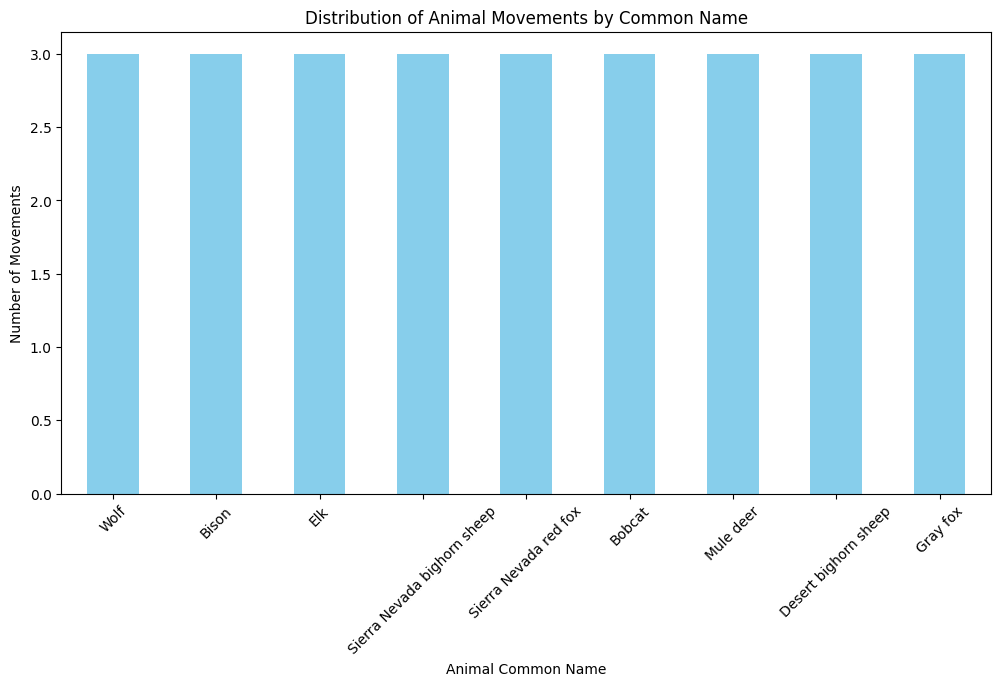

In [70]:
# Merge animal events with animal metadata
merged_df = animal_events_gdf.merge(animals_df, on='animal_id')

# Count the number of movements per animal common name
common_name_counts = merged_df['common_name'].value_counts()

# Plot the distribution of animal movements by common name
common_name_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Distribution of Animal Movements by Common Name')
plt.xlabel('Animal Common Name')
plt.ylabel('Number of Movements')
plt.xticks(rotation=45)
plt.show()

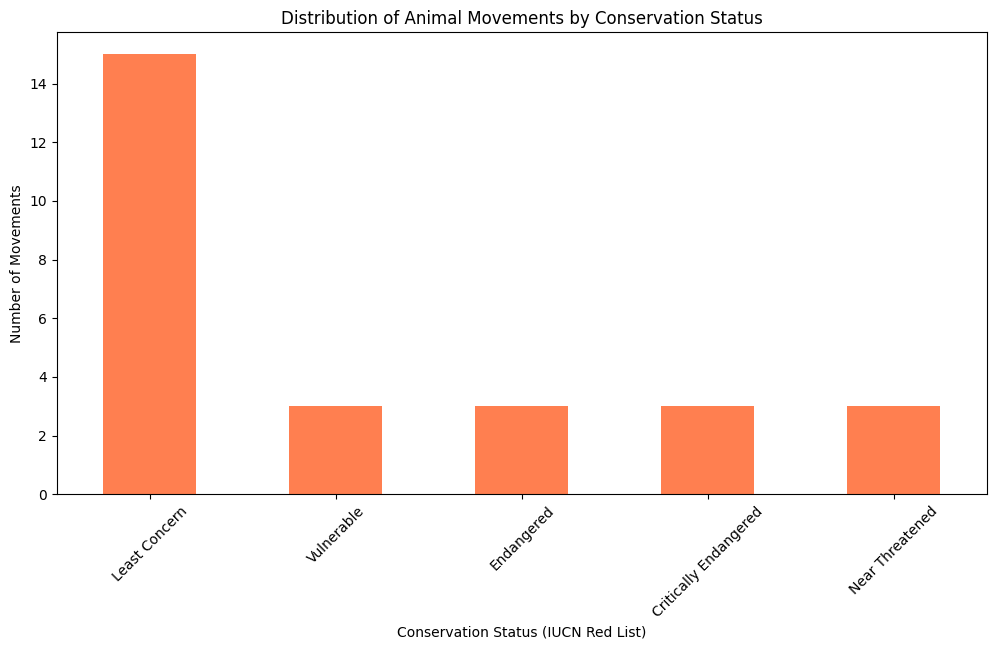

In [16]:
# Count the number of movements per redlist category
redlist_counts = merged_df['redlist_cat'].value_counts()

# Plot the distribution of animal movements by conservation status
redlist_counts.plot(kind='bar', figsize=(12, 6), color='coral')
plt.title('Distribution of Animal Movements by Conservation Status')
plt.xlabel('Conservation Status (IUCN Red List)')
plt.ylabel('Number of Movements')
plt.xticks(rotation=45)
plt.show()


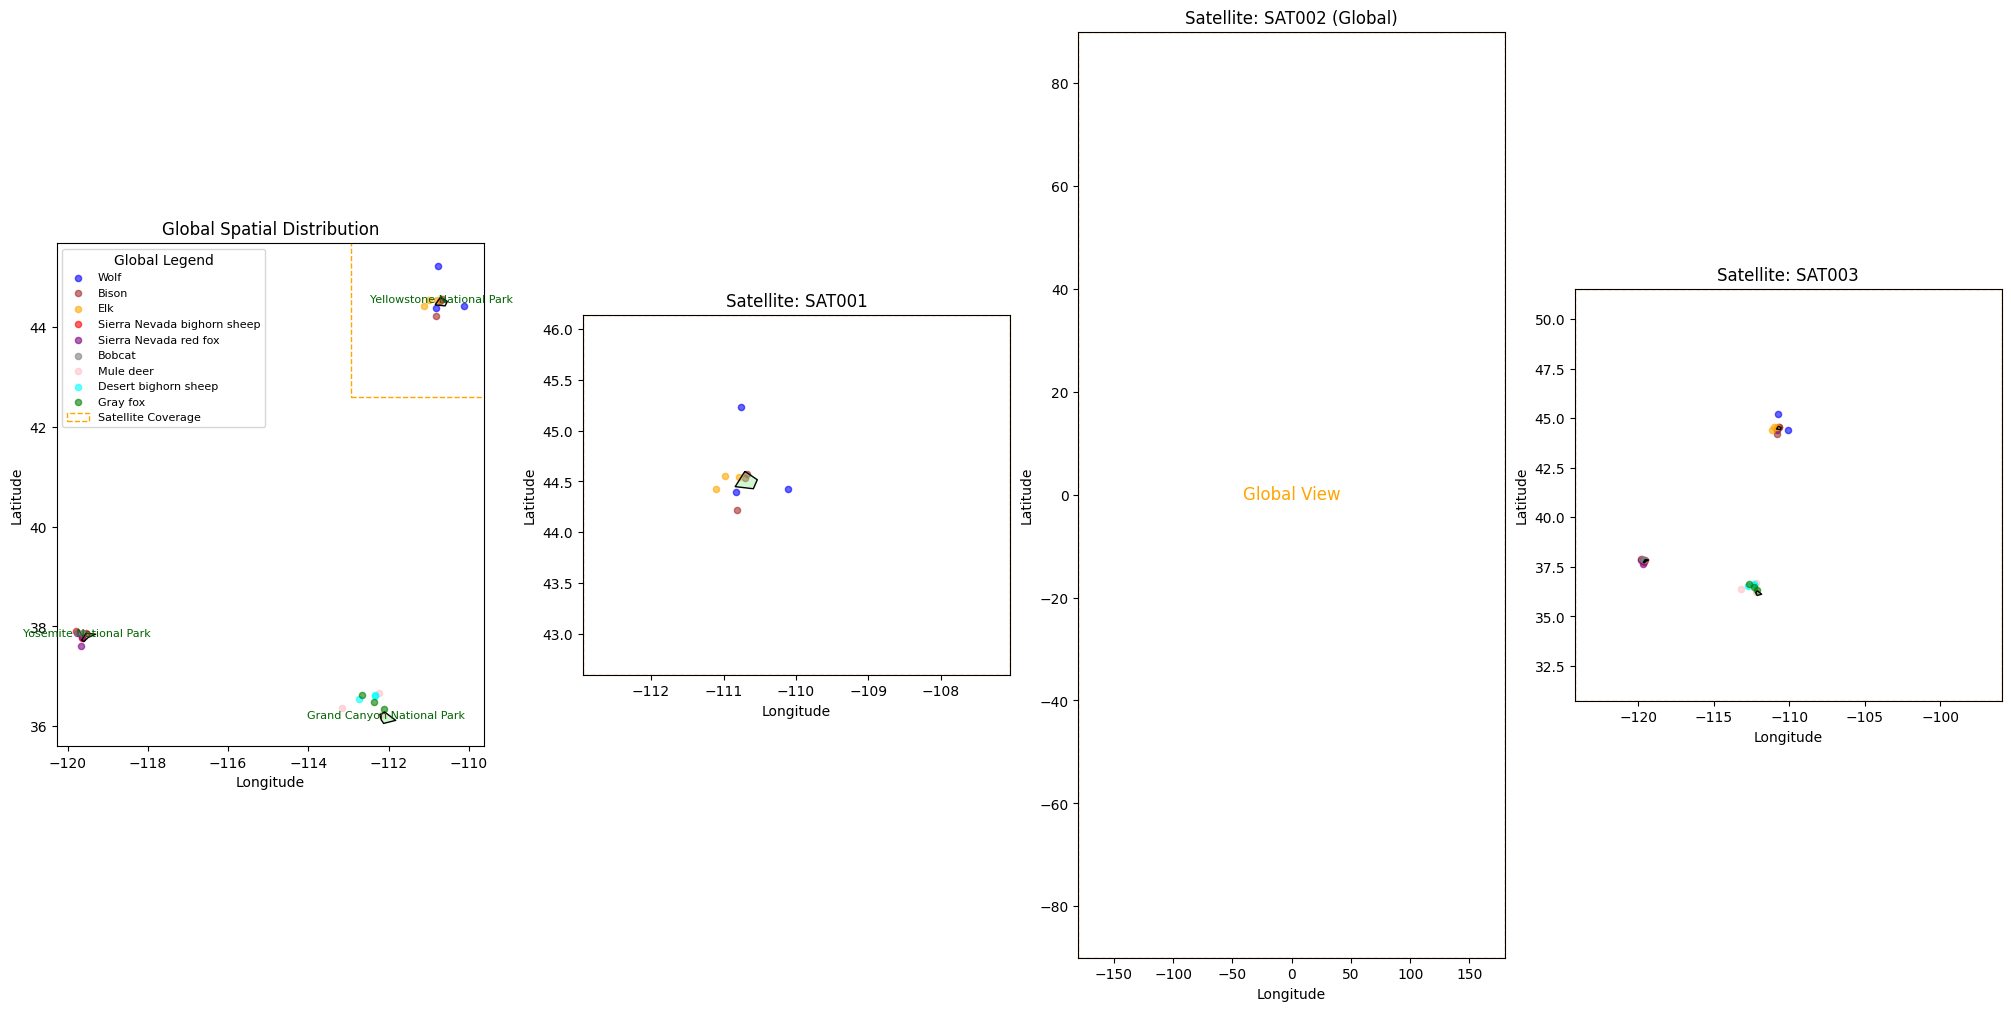

In [90]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Import patches for creating rectangles
import geopandas as gpd
import pandas as pd

# Merge animal_events_gdf with animals_df to include the 'common_name' column if not already merged
animal_events_gdf = animal_events_gdf.merge(animals_df, on='animal_id', how='left')

# Plot the global plot and subplots for each satellite coverage
satellite_df = pd.read_sql('SELECT * FROM satellites', engine)

# Determine the number of subplots (1 global + 1 for each satellite)
num_subplots = len(satellite_df) + 1

# Set up the figure and subplots
fig, axs = plt.subplots(1, num_subplots, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()

# 1. Global Plot (First subplot)
ax_global = axs[0]

# Unique colors for each animal species
animal_colors = {
    'Wolf': 'blue',
    'Bison': 'brown',
    'Elk': 'orange',
    'Sierra Nevada bighorn sheep': 'red',
    'Sierra Nevada red fox': 'purple',
    'Bobcat': 'gray',
    'Mule deer': 'pink',
    'Desert bighorn sheep': 'cyan',
    'Gray fox': 'green'
}

# Plot protected areas with labels (Global Plot)
protected_areas_gdf.boundary.plot(ax=ax_global, color='black', linewidth=1)
protected_areas_gdf.plot(ax=ax_global, color='lightgreen', alpha=0.4)
for idx, row in protected_areas_gdf.iterrows():
    ax_global.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                       horizontalalignment='center', fontsize=8, color='darkgreen', labels='protected_areas')

# Plot animal movements differentiated by species (Global Plot)
for species, color in animal_colors.items():
    subset = animal_events_gdf[animal_events_gdf['common_name'] == species]
    subset.plot(ax=ax_global, markersize=20, color=color, label=species, alpha=0.6, marker='o')

# Plot satellite bounding boxes (Global Plot)
for _, row in satellite_df.iterrows():
    rect = mpatches.Rectangle(
        (row['bounding_box.xmin'], row['bounding_box.ymin']),  # Lower-left corner
        row['bounding_box.xmax'] - row['bounding_box.xmin'],   # Width
        row['bounding_box.ymax'] - row['bounding_box.ymin'],   # Height
        linewidth=1, edgecolor='orange', facecolor='none', linestyle='--'
    )
    ax_global.add_patch(rect)

# Add the satellite coverage label to the global plot legend
satellite_patch = mpatches.Patch(edgecolor='orange', facecolor='none', linestyle='--', label='Satellite Coverage')
ax_global.legend(handles=ax_global.get_legend_handles_labels()[0] + [satellite_patch], loc='upper left', fontsize=8, title='Global Legend')

# Set global plot title
ax_global.set_title('Global Spatial Distribution')
ax_global.set_xlabel('Longitude')
ax_global.set_ylabel('Latitude')

import shapely.geometry

# Subplots for Each Satellite Coverage
for idx, row in satellite_df.iterrows():
    ax = axs[idx + 1]  # Start from the second subplot
    
    # Create a rectangular patch for the subplot
    rect = mpatches.Rectangle(
        (row['bounding_box.xmin'], row['bounding_box.ymin']),  # Lower-left corner
        row['bounding_box.xmax'] - row['bounding_box.xmin'],   # Width
        row['bounding_box.ymax'] - row['bounding_box.ymin'],   # Height
        linewidth=1, edgecolor='orange', facecolor='none', linestyle='--'
    )
    ax.add_patch(rect)
    
    # Create a Polygon for the satellite bounding box
    satellite_coverage_polygon = shapely.geometry.box(
        row['bounding_box.xmin'], row['bounding_box.ymin'],
        row['bounding_box.xmax'], row['bounding_box.ymax']
    )
    
    # Convert the polygon into a GeoDataFrame
    satellite_coverage_box = gpd.GeoDataFrame(
        geometry=[satellite_coverage_polygon], crs='EPSG:4326'
    )
    
    # Check if this is a global bounding box
    is_global_box = (row['bounding_box.xmin'] == -180 and row['bounding_box.ymin'] == -90 and
                     row['bounding_box.xmax'] == 180 and row['bounding_box.ymax'] == 90)
    
    if is_global_box:
        # Set a global plot limit manually for visualization
        ax.set_xlim([-180, 180])
        ax.set_ylim([-90, 90])
        ax.set_title(f"Satellite: {row['satellite_id']} (Global)")
        ax.text(0, 0, 'Global View', horizontalalignment='center', verticalalignment='center', fontsize=12, color='orange')
    else:
        # Filter and plot animal events within this satellite bounding box
        animals_in_box = gpd.sjoin(animal_events_gdf, satellite_coverage_box, predicate='within')
        for species, color in animal_colors.items():
            subset = animals_in_box[animals_in_box['common_name'] == species]
            if not subset.empty:
                subset.plot(ax=ax, markersize=20, color=color, alpha=0.6, marker='o')

        # Plot the protected areas that intersect with the satellite box
        protected_in_box = gpd.overlay(protected_areas_gdf, satellite_coverage_box, how='intersection')
        protected_in_box.plot(ax=ax, color='lightgreen', alpha=0.4)
        protected_in_box.boundary.plot(ax=ax, color='black', linewidth=1)
        
        # Set appropriate limits and title
        ax.set_xlim([row['bounding_box.xmin'], row['bounding_box.xmax']])
        ax.set_ylim([row['bounding_box.ymin'], row['bounding_box.ymax']])
        ax.set_title(f"Satellite: {row['satellite_id']}")
        
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Show the complete plot with global and subplots
plt.show()

#### 2.3 Behavioral Analysis

In [27]:
# Fetch satellite data from the database
satellite_df = pd.read_sql('SELECT * FROM satellites', engine)

# Convert timestamps to datetime
satellite_df['start_time'] = pd.to_datetime(satellite_df['start_time'])
satellite_df['last_time'] = pd.to_datetime(satellite_df['last_time'])

# Display the satellite data from the database
satellite_df.head()


,satellite_id,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424
1,SAT002,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000
2,SAT003,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929


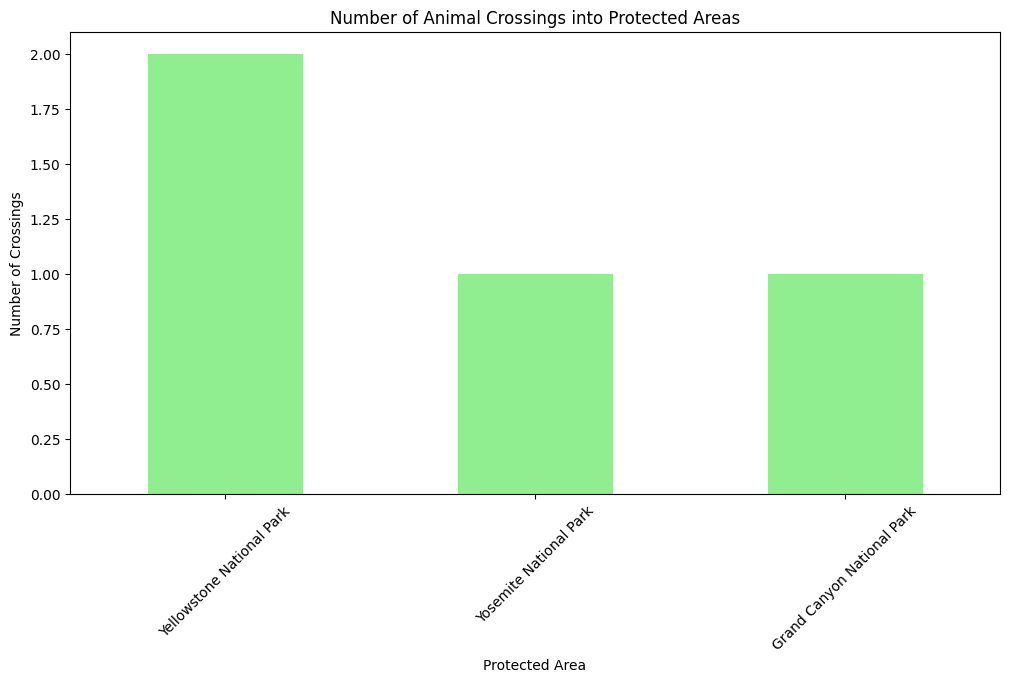

In [31]:
# Perform spatial join to determine animal entries into protected areas
crossings = gpd.sjoin(animal_events_gdf, protected_areas_gdf, how='inner', predicate='within')

# Count the number of crossings by protected area
crossings_by_area = crossings['name'].value_counts()

# Plot the number of crossings per protected area
crossings_by_area.plot(kind='bar', figsize=(12, 6), color='lightgreen')
plt.title('Number of Animal Crossings into Protected Areas')
plt.xlabel('Protected Area')
plt.ylabel('Number of Crossings')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Define a function to get satellite info overlapping with animal event times
def get_satellite_info_from_db(event_time, satellites):
    relevant_satellites = satellites[(satellites['start_time'] <= event_time) & (satellites['last_time'] >= event_time)]
    return relevant_satellites['cloud_cover_percentage'].mean() if not relevant_satellites.empty else None

# Add satellite cloud cover percentage to the crossings DataFrame
# Convert the timestamp to naive datetime by removing the timezone
# crossings['timestamp'] = crossings['timestamp'].dt.tz_localize(None)
# Add satellite cloud cover percentage to the crossings DataFrame
crossings['cloud_cover_percentage'] = crossings['timestamp'].apply(lambda x: get_satellite_info_from_db(x, satellite_df))

# Display the crossings DataFrame with satellite info
crossings.head()
# Display the crossings DataFrame with satellite info
crossings.head()

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

#### 2.4 Advanced Insights

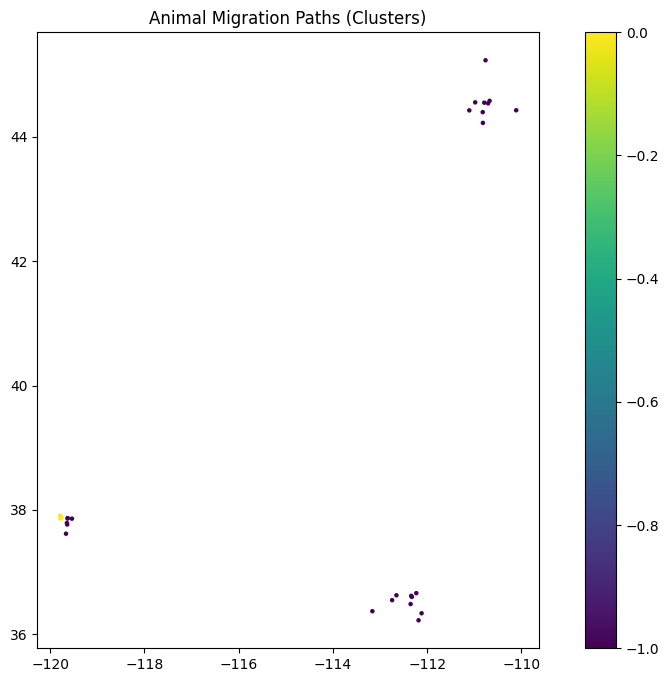

In [22]:

from sklearn.cluster import DBSCAN

# Extract coordinates for clustering
coords = animal_events_gdf[['longitude', 'latitude']].to_numpy()

# Perform clustering
db = DBSCAN(eps=0.05, min_samples=3).fit(coords)
animal_events_gdf['cluster'] = db.labels_

# Plot migration paths by cluster
fig, ax = plt.subplots(figsize=(12, 8))
animal_events_gdf.plot(column='cluster', ax=ax, legend=True, cmap='viridis', markersize=5)
plt.title('Animal Migration Paths (Clusters)')
plt.show()

,satellite_id,start_time,last_time,frequency,bounding_box,cloud_cover_percentage,resolution
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,"{'xmin': -112.939131, 'ymin': 42.596356, 'xmax...",12.5,10m
1,SAT002,2004-09-01 12:00:00+00:00,2024-09-06 12:00:00+00:00,bi-weekly,"{'xmin': -180, 'ymin': -90, 'xmax': 180, 'ymax...",10.0,100m
2,SAT003,2022-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,hourly,"{'xmin': -124.178099, 'ymin': 30.738207, 'xmax...",10.0,20m
